In [81]:
###Project 2
#Setup copied from project 1
import os
import numpy as np
import mglearn as mgl
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d
from sklearn.impute import SimpleImputer
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib as mp
import matplotlib.pyplot as plt
import ctypes
hllDll = ctypes.WinDLL("C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.7\\bin\\cudart64_110.dll")
import tensorflow as tf

#%%
###Load & format our dataset
GAMMA = pd.read_csv("https://raw.githubusercontent.com/Disco-Gnome/DATA712/main/magic04.data",
                           sep=",")
GAMMA.columns = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','gamma']

GAMMA['gamma_enc'] = GAMMA['gamma']
GAMMA['gamma_enc'].replace({'g':"1", 'h':"0"},
                           inplace=True)
GAMMA['gamma_enc'] = GAMMA['gamma_enc'].astype(int)
GAMMA = GAMMA.drop('gamma', axis=1)

###Create Training & Testing sets
GAMMA_X = GAMMA.drop(['gamma_enc'], axis=1)
GAMMA_y = GAMMA['gamma_enc']
X_train, X_test, y_train, y_test = train_test_split(GAMMA_X,
                                                    GAMMA_y,
                                                    random_state=1,
                                                    stratify=GAMMA_y)

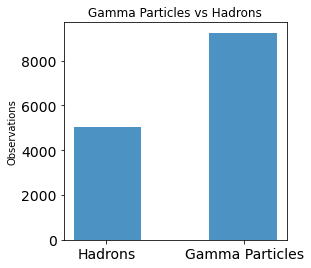

In [82]:
###Project 2
###Examine Target Attribute
#Target attribute in our training data
y_train.plot(kind='hist',
             alpha=0.8,
             title="Gamma Particles vs Hadrons",
             grid=False,
             figsize=(4,4),
             fontsize=14,
             bins=3)
plt.ylabel("Observations")
plt.xticks([0.16, 0.84], ["Hadrons", "Gamma Particles"])
plt.show()

#our data is approximately 65% gamma particles and 35% hadrons,
#meaning that random guessing would have apx 65% accuracy.

In [83]:
###Method 1: K-Nearest Neighbors
#I start by choosing an arbitrary value for k
knn4 = KNeighborsClassifier(n_neighbors=4)
knn4.fit(X_train, y_train)
print("knn score for 4 neighbors: {}".format(knn4.score(X_train, y_train)))

knn score for 4 neighbors: 0.8766825574873808


In [84]:
#Default Parameters with Cross-validation
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
cv20 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
cv_scores = cross_val_score(knn, X_train, y_train, cv=cv20)
print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))

#5-fold stratified cross validation finds an average CV score of about 81%

cv_scores:
[0.80581844 0.80126183 0.80196285 0.80476691 0.80651945]
cv_scores mean:
0.8040658955485455


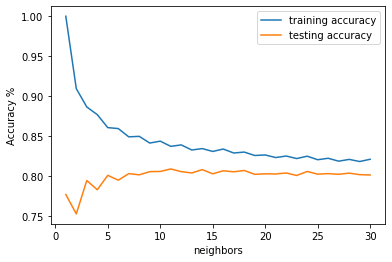

In [85]:
#Testing different values
training_accuracy = []
testing_accuracy = []
neighbors_settings = range(1,31)
for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    training_accuracy.append(knn.score(X_train, y_train))
    testing_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, testing_accuracy, label="testing accuracy")
plt.ylabel('Accuracy %')
plt.xlabel("neighbors")
plt.legend()

knn score for 10 neighbors: 0.8434520471116096


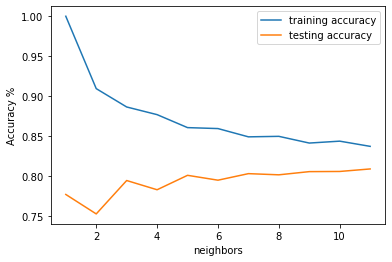

In [86]:
#Values appear to stagnate past about 10, so
#I want to zoom in to that area to get a better
#identify an optimal value
training_accuracy = []
testing_accuracy = []
neighbors_settings = range(1,12)
for n_neighbors in neighbors_settings:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    training_accuracy.append(knn.score(X_train, y_train))
    testing_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, testing_accuracy, label="testing accuracy")
plt.ylabel('Accuracy %')
plt.xlabel("neighbors")
plt.legend()

#Optimal number of neighbors for otherwise default KNN
#appears to be about 10.
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(X_train, y_train)
print("knn score for 10 neighbors: {}".format(knn10.score(X_train, y_train)))

In [87]:
#Grid Search
knn_cv = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 12),
              "weights": ["uniform","distance"],
              "algorithm": ["ball_tree","kd_tree","brute"]}
knn_gscv = GridSearchCV(knn_cv, param_grid, cv=cv20)
knn_gscv.fit(X_train, y_train)
print("Best parameters:", knn_gscv.best_params_)
print("Best score:", knn_gscv.best_score_)
#The maximum accuracy for best parameters here (81.5%) is
#nearly identical to the highest accuracy that could be 
#achieved for kNN in the original publication (81.6%).

Best parameters: {'algorithm': 'ball_tree', 'n_neighbors': 11, 'weights': 'distance'}
Best score: 0.8153522607781284


In [89]:
#Evaluating our best model
knn_opt = KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10, weights='distance')
knn_opt.fit(X_train, y_train)
confusion = confusion_matrix(y_test, knn_opt.predict(X_test))
print("Confusion matrix:\n{}".format(confusion))

#A confusion matrix finds that our model tends to find 
#more false positives (707) than false negatives (205).
#According to related research, this is desirable because 
#the cost of false positives (which can later be reviewed
#by human researchers) is lower than the cost of false negatives.

Confusion matrix:
[[ 976  696]
 [ 210 2873]]


In [90]:
#Classification Report
print(classification_report(y_test, knn_opt.predict(X_test), 
                            target_names=["Hadrons", "Gamma Particles"]))

                 precision    recall  f1-score   support

        Hadrons       0.82      0.58      0.68      1672
Gamma Particles       0.80      0.93      0.86      3083

       accuracy                           0.81      4755
      macro avg       0.81      0.76      0.77      4755
   weighted avg       0.81      0.81      0.80      4755



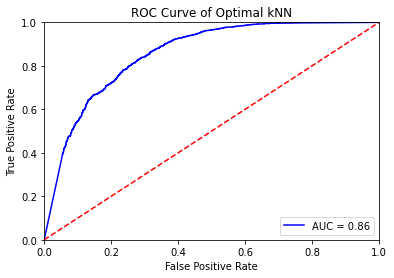

In [63]:
#ROC Curve
y_scores = knn_opt.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Optimal kNN')
plt.show()

In [64]:
###Methods 2 & 3: Random Forest & Gradient Boosted Decision Tree
#I focus more on random forests, but I included GBDT as a third method
#because I want to include it in my final paper.
#For the optimization and grid search steps, I used small values here
#to speed up calculation. For the final project, I'll use larger values.
#Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.885


In [65]:
#GBRT
gbrt = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=1)
gbrt.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.884
Accuracy on test set: 0.869


In [66]:
#Cross validation with default parameters [Forest]
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
cv_scores = cross_val_score(forest, X_train, y_train, cv=cv20)
print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))

cv_scores:
[0.86926043 0.87031195 0.87311602 0.87977567 0.87732212]
cv_scores mean:
0.8739572379950928


In [67]:
#Cross validation with default parameters [GBRT]
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train, y_train)
cv_scores = cross_val_score(gbrt, X_train, y_train, cv=cv20)
print("cv_scores:\n{}".format(cv_scores))
print("cv_scores mean:\n{}".format(np.mean(cv_scores)))

cv_scores:
[0.86189975 0.86505433 0.8640028  0.8766211  0.87767263]
cv_scores mean:
0.869050122677883


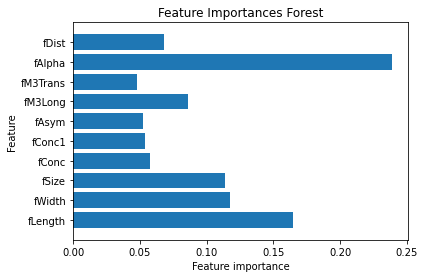

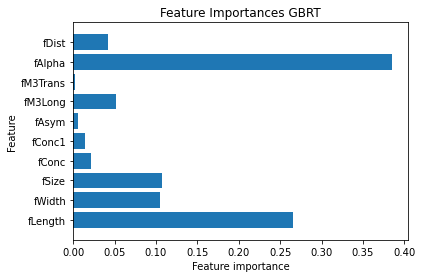

In [68]:
#Evaluation Metrics
def plot_feature_importances_GAMMA(model):
    n_features = X_train.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X_train.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_GAMMA(forest)
plt.title("Feature Importances Forest")
plt.show()

plot_feature_importances_GAMMA(gbrt)
plt.title("Feature Importances GBRT")
plt.show()

#Both models show particular importance for fAlpha first, fLength second
#and fWidth and fSize alternatingly 3rd and 4th.

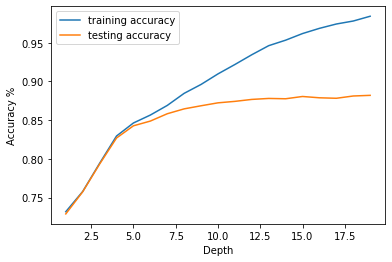

In [69]:
#Evaluating different maximum depths
training_accuracy = []
testing_accuracy = []
depth_settings = range(1,20)
for depth in depth_settings:
    forest = RandomForestClassifier(max_depth=depth)
    forest.fit(X_train, y_train)
    training_accuracy.append(forest.score(X_train, y_train))
    testing_accuracy.append(forest.score(X_test, y_test))

plt.plot(depth_settings, training_accuracy, label="training accuracy")
plt.plot(depth_settings, testing_accuracy, label="testing accuracy")
plt.ylabel('Accuracy %')
plt.xlabel('Depth')
plt.legend()
#Increasing maximum depth yields diminishing returns past about 9.

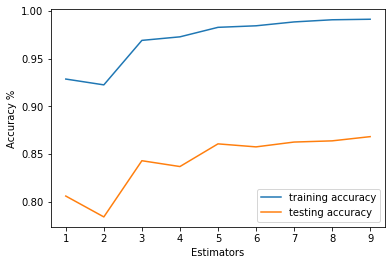

In [70]:
#Evaluating different maximum estimators
training_accuracy = []
testing_accuracy = []
estimator_settings = range(1,10)
for estimators in estimator_settings:
    forest = RandomForestClassifier(n_estimators=estimators)
    forest.fit(X_train, y_train)
    training_accuracy.append(forest.score(X_train, y_train))
    testing_accuracy.append(forest.score(X_test, y_test))

plt.plot(estimator_settings, training_accuracy, label="training accuracy")
plt.plot(estimator_settings, testing_accuracy, label="testing accuracy")
plt.ylabel('Accuracy %')
plt.xlabel('Estimators')
plt.legend()
#Increasing the number of estimators appears to yield diminishing
#returns past about 7.

In [72]:
#Forest Grid Search
cv20 = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=1)
forest_GS = RandomForestClassifier()
estimators_range = [5]
criterion_options = ['gini', 'entropy']
max_depth_range = np.arange(1, 10)
max_features_range = np.arange(1, 10)
param_grid = dict(n_estimators=estimators_range,
                  criterion=criterion_options,
                  max_depth=max_depth_range,
                  max_features=max_features_range)
gridForest = GridSearchCV(forest_GS, param_grid = param_grid, cv=cv20)
gridForest.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (gridForest.best_params_, gridForest.best_score_))
#This seems to run much slower here than in my IDE, so I
#reduced the estimators range to a single small value. In 
#the final project, I will use a larger range

The best parameters are {'criterion': 'entropy', 'max_depth': 9, 'max_features': 8, 'n_estimators': 5} with a score of 0.86


In [73]:
#GBRT Grid Search
GBRT_GS = GradientBoostingClassifier()
loss_options = ['deviance', 'exponential']
learning_rate_range = np.arange(0.1,0.9)
estimators_range = [5]
criterion_options = ['friedman_mse', 'squared_error']
max_depth_range = np.arange(1, 10)
max_features_range = ['auto', 'sqrt', 'log2']
param_grid = dict(loss=loss_options,
                  learning_rate=learning_rate_range,
                  n_estimators=estimators_range,
                  criterion=criterion_options,
                  max_depth=max_depth_range,
                  max_features=max_features_range)
gridGBRT = GridSearchCV(GBRT_GS, param_grid = param_grid, cv=cv20)
gridGBRT.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (gridGBRT.best_params_, gridGBRT.best_score_))

The best parameters are {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 5} with a score of 0.84


In [74]:
#Optimal Forest
forest_opt = RandomForestClassifier(criterion='entropy',
                                    max_depth=9,
                                    max_features=7,
                                    n_estimators=100)
forest_opt.fit(X_train, y_train)

#Optimal GBRT
GBRT_opt = GradientBoostingClassifier(criterion='squared_error',
                                      learning_rate=0.1,
                                      loss='deviance',
                                      max_depth=7,
                                      max_features='sqrt',
                                      n_estimators=100)
GBRT_opt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='squared_error', max_depth=7,
                           max_features='sqrt')

In [75]:
###Evaluating our optimal Forest
#Confusion Matrix
confusion = confusion_matrix(y_test, forest_opt.predict(X_test))
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[1207  465]
 [ 137 2946]]


In [76]:
#Classification Report
print(classification_report(y_test, forest_opt.predict(X_test),
                            target_names=["Hadron", "Gamma Particles"]))

                 precision    recall  f1-score   support

         Hadron       0.90      0.72      0.80      1672
Gamma Particles       0.86      0.96      0.91      3083

       accuracy                           0.87      4755
      macro avg       0.88      0.84      0.85      4755
   weighted avg       0.88      0.87      0.87      4755



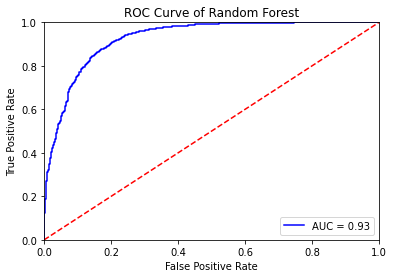

In [77]:
#ROC Curve
y_scores = forest_opt.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

In [78]:
###Evaluating our optimal GBRT
#Confusion Matrix
confusion = confusion_matrix(y_test, GBRT_opt.predict(X_test))
print("Confusion matrix:\n{}".format(confusion))
#Both the RF and GBRT models produce fewer false positives
#and fewer false negatives than kNN.

Confusion matrix:
[[1279  393]
 [ 170 2913]]


In [79]:
#Classification Report
print(classification_report(y_test, GBRT_opt.predict(X_test),
                            target_names=["Hadron", "Gamma Particles"]))
#Both the RF and GBRT models score higher at precision, recall,
#and f1-score for both classes in our data.

                 precision    recall  f1-score   support

         Hadron       0.88      0.76      0.82      1672
Gamma Particles       0.88      0.94      0.91      3083

       accuracy                           0.88      4755
      macro avg       0.88      0.85      0.87      4755
   weighted avg       0.88      0.88      0.88      4755



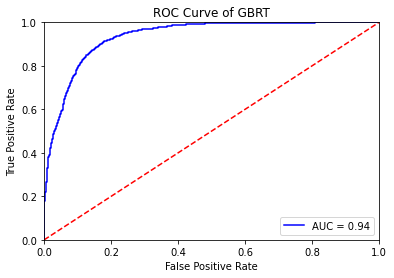

In [80]:
#ROC Curve
y_scores = GBRT_opt.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of GBRT')
plt.show()

In [ ]:
#Both ROC curves seems to show a relatively steep curve,
#closer to an ideal right-angle than that of our kNN.

#Overall, evaluations show that both RF and GBRT models
#work better at discriminating between the classes in
#our data than kNN.